## 🧬 Understanding Antibiotic Resistance Patterns: A Data-Driven Exploration

Antibiotic resistance is one of the most pressing challenges in modern medicine.  
While new antibiotics are continually developed, the ability of bacteria to adapt and survive often outpaces innovation, making data-driven surveillance an essential tool in understanding — and hopefully mitigating — this global threat.

This analysis explores a synthetic dataset simulating patient records and bacterial susceptibility results, with the aim of identifying key relationships between **demographic factors**, **infection frequency**, and **bacterial resistance profiles**.  
The goal is not only to uncover descriptive trends, but also to evaluate whether certain variables — such as age, gender, or comorbidities — correlate with the severity or recurrence of infections.

The workflow follows a structured exploratory data analysis (EDA) approach:
1. **Data Cleaning & Preparation** – handling missing values, standardizing inconsistent entries, and extracting structured features such as `Age`, `Gender`, and geographic fields from unstructured text.  
2. **Demographic Exploration** – assessing the distribution of infections across age groups, genders, and states to identify population-level patterns.  
3. **Temporal & Geographic Trends** – visualizing how infections evolve over time and across U.S. regions, using faceted and choropleth plots.  
4. **Bacterial Analysis** – identifying the most frequent bacterial strains, comparing infection severity across them, and examining how resistance levels vary by antibiotic.  

Each step is accompanied by visual exploration, statistical testing, and interpretative commentary, connecting the data to meaningful clinical and epidemiological questions.

> **Objective:**  
> To provide a transparent, data-centric view of antibiotic resistance behavior — not to replace clinical research, but to demonstrate how exploratory analytics can support evidence-based decision-making and hypothesis generation.

In the following sections, we’ll progressively move from broad descriptive insights (e.g., patient distribution and infection trends) to more targeted questions about bacterial strain behavior and antibiotic response patterns — culminating in a resistance heatmap summarizing the overall resistance profile across antibiotics and bacterial species.

## 1. Setup & Imports
We use Pandas for data handling, Plotly for interactive charts, and scikit‑learn for the ML pipeline.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,  roc_curve
from sklearn.pipeline import Pipeline
import textwrap
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 120)



## 2. Load Dataset
Point `csv_path` to your file. If your target labels are not already binary (e.g., `'R'` vs `'S'`), we map them to 1/0.

In [39]:
!kaggle datasets download -d adilimadeddinehosni/multi-resistance-antibiotic-susceptibility -p ./data
!unzip -o ./data/multi-resistance-antibiotic-susceptibility.zip -d ./data

pd.set_option('display.max_columns', None)
df = pd.read_csv('data/Bacteria_dataset_Multiresistance.csv')

df.head(4)

Dataset URL: https://www.kaggle.com/datasets/adilimadeddinehosni/multi-resistance-antibiotic-susceptibility
License(s): CC-BY-NC-SA-4.0
multi-resistance-antibiotic-susceptibility.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/multi-resistance-antibiotic-susceptibility.zip
  inflating: ./data/Bacteria_dataset_Multiresictance.csv  


,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,5 Fev 2025,Patient had fever??
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,08/05/2021,تم العلاج
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,01/05/2022,NADA
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO


In [40]:
dictionary = pd.read_csv('data/columns_dictionary.csv')
dictionary

,Column_Name,Description
0,ID,Unique patient or bacterial sample identifier
1,Name,Full name of the patient
2,Email,Patient contact email
3,Address,Complete address before parsing
4,age/gender,"Original combined field for age and gender (e.g. ""40/F"")"
5,Souches,Raw bacterial strain code
6,Diabetes,Indicates if the patient has diabetes
7,Hypertension,Indicates if the patient has hypertension
8,Hospital_before,Whether the patient was previously hospitalized
9,Infection_Freq,Frequency of infection episodes


## 3. Data Overview & Quality Checks
Basic structure, missingness, and categorical cardinality.

In [41]:
#get basic dataframe info
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data types:\n", df.dtypes)

#review missing values
print("Missing values per column:\n",)
df.isnull().sum().sort_values(ascending=False)

Dataset shape: (10710, 27)
Columns: ['ID', 'Name', 'Email', 'Address', 'age/gender', 'Souches', 'Diabetes', 'Hypertension', 'Hospital_before', 'Infection_Freq', 'AMX/AMP', 'AMC', 'CZ', 'FOX', 'CTX/CRO', 'IPM', 'GEN', 'AN', 'Acide nalidixique', 'ofx', 'CIP', 'C', 'Co-trimoxazole', 'Furanes', 'colistine', 'Collection_Date', 'Notes']
Data types:
 ID                   object
Name                 object
Email                object
Address              object
age/gender           object
Souches              object
Diabetes             object
Hypertension         object
Hospital_before      object
Infection_Freq       object
AMX/AMP              object
AMC                  object
CZ                   object
FOX                  object
CTX/CRO              object
IPM                  object
GEN                  object
AN                   object
Acide nalidixique    object
ofx                  object
CIP                  object
C                    object
Co-trimoxazole       object
Furanes   

Collection_Date      669
AMX/AMP              658
GEN                  643
Souches              640
Co-trimoxazole       640
Infection_Freq       639
Hospital_before      637
Furanes              637
colistine            636
Diabetes             635
IPM                  633
CIP                  633
AMC                  632
Hypertension         630
C                    629
CZ                   628
AN                   628
FOX                  625
CTX/CRO              624
Acide nalidixique    622
age/gender           621
ofx                  618
Notes                112
Name                   0
Address                0
Email                  0
ID                     0
dtype: int64

### 4. Clean - Data Wrangling

In [42]:
# Extact city and state from addess column
df[['street', 'city', 'state', 'zip']] = df['Address'].str.extract(
    r'^(.*?),\s*(?:([A-Za-z\s]+|FPO|APO|DPO)\s+)?([A-Z]{2})\s*(\d{5})$'
)

# Extract Souche_ID and Souche_description
df[['Souche_ID', 'Souche_description']] = df['Souches'].str.extract(r'^(S?\d+)\s+(.*)$')


In [43]:
# Verify Collection_Date format, how many unique values are there?
df['Collection_Date'].value_counts()

Collection_Date
2024-12-31    1461
2020-01-05    1337
08/05/2021     719
5 Fev 2025     712
05/01/2025     708
05/03/2022     696
2020-12-31     693
2023-12-31     693
01/05/2022     692
3 Jan 1019     684
?              603
missing        535
error          508
Name: count, dtype: int64

In [44]:
# It is reasonable to assume that '3 Jan 1019' is a typo and should be '3 Jan 2019'
df['Collection_Date'] = df['Collection_Date'].replace({'3 Jan 1019': '3 Jan 2019'})

# Clean and convert Collection_Date to datetime
df['Collection_Date'] = df['Collection_Date'].astype(str).str.strip()
df['Collection_Date'] = df['Collection_Date'].replace(['?', 'missing', 'error'], None)
df['Collection_Date'] = pd.to_datetime(df['Collection_Date'], errors='coerce', dayfirst=True)

# Verify Collection_Date format, how many unique values are there?
df['Collection_Date'].value_counts()

Collection_Date
2024-12-31    1461
2020-01-05    1337
2021-05-08     719
2025-01-05     708
2022-03-05     696
2020-12-31     693
2023-12-31     693
2022-05-01     692
2019-01-03     684
Name: count, dtype: int64

In [45]:
# Check rows with missing state
df[df['state'].isna()][['Address', 'street', 'city', 'state', 'zip']].count()

Address    0
street     0
city       0
state      0
zip        0
dtype: int64

In [46]:
# Extract Age and Gender
df[['Age', 'Gender']] = df['age/gender'].str.extract(r'(\d+)\s*/?\s*([MF])?', expand=True)

# Convert age to numeric, coercing errors to NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Fill missing gender values with NaN
df['Gender'] = df['Gender'].replace('', np.nan)

df.head(4)

,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes,street,city,state,zip,Souche_ID,Souche_description,Age,Gender
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia coli,37.0,F
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella morganii,29.0,F
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus mirabilis,77.0,F
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,"1670 Thompson Way Apt. 520, Andrewbury",NaN,IL,11534,NaN,NaN,NaN,NaN


In [47]:
# assign gender according to first names
male_names = {
    'Aaron','Abdullah','Adam','Adriano','Adrian','Ahmad','Alain','Alan','Albert','Alberto','Aldo','Alec',
    'Alejandro','Alessandro','Alex','Alexander','Alexandre','Alfonso','Alfred','Alfredo','Ali','Amedeo',
    'Amir','Anders','Andoni','Andre','Andrea','Andreas','Andrew','Andrey','Andy','Angel','Angelo','Anthony',
    'Antonio','Antoine','Anton','Antonio','Armand','Arnaud','Arnold','Arthur','Arturo','Augusto','Austin',
    'Barry','Ben','Benjamin','Bernard','Bill','Billy','Boris','Brad','Brandon','Brian','Bruno','Bryan','Caleb',
    'Carl','Carlos','Carlo','Carmelo','Casper','Cédric','Cesare','Charles','Charlie','Chris','Christian',
    'Christopher','Claude','Claudio','Colin','Connor','Craig','Cristian','Cristiano','Curtis','Damian',
    'Daniel','Danny','Dario','Darren','David','Davide','Dean','Dennis','Derek','Diego','Dimitri','Dominic',
    'Donald','Douglas','Dylan','Edoardo','Edouard','Eduardo','Edward','Edwin','Elias','Elio','Eliseo','Emanuele',
    'Emilio','Emmanuel','Enrico','Enrique','Eric','Erik','Erin','Ernesto','Ethan','Ettore','Eugenio','Eusebio','Fabian',
    'Fabio','Federico','Felipe','Felix','Fernando','Filippo','Flavio','Francesco','Francis','Francisco','Frank',
    'Franco','Fred','Frederic','Frederick','Gabriel','Gael','Gabriele','Gaston','Gavin','Geoffrey','George',
    'Gerald','Germain','Giacomo','Gianluca','Gino','Giovanni','Giuseppe','Giulio','Glen','Gordon','Greg',
    'Gregory','Guido','Guillaume','Guillermo','Gustavo','Hector','Henry','Hugo','Ian','Ibrahim','Igor','Isaac',
    'Ismael','Ivan','Jack','Jacob','Jake','James','Jamie','Jason','Jean','Jeff','Jeffrey','Jerome','Jerry',
    'Jesse','Jesus','Jim','Jimmy','Joe','Joel','John','Johnny','Jonathan','Jordan','Jorge','Jose','Joseph',
    'Josh','Joshua','Juan','Julian','Julien','Justin','Karl','Kevin','Khaled','Kieran','Landon','Larry','Laurent',
    'Lawrence','Leo','Leon','Leonard','Leonardo','Liam','Lorenzo','Louis','Luc','Luca','Lucas','Luciano',
    'Luigi','Luis','Luka','Luke','Manuel','Marc','Marcel','Marco','Marcus','Mario','Mark','Martin','Marvin',
    'Massimo','Matteo','Matthew','Maurice','Maurizio','Max','Maximilian','Michael','Michele','Miguel','Mike',
    'Mirko','Mohamed','Mohammed','Nadir','Nathan','Nicholas','Nicolas','Nico','Nigel','Noah','Norbert','Olivier',
    'Oscar','Pablo','Paolo','Patrick','Paul','Pedro','Pietro','Pierre','Rafael','Raimondo','Ralph','Ramon',
    'Raul','Raymond','Remy','Renato','Ricardo','Richard','Rick','Robert','Roberto','Rodrigo','Roger','Roland',
    'Romain','Roman','Romeo','Ronald','Ruben','Russell','Ryan','Salvatore','Sam','Samuel','Sandro','Scott',
    'Sean','Sebastian','Serge','Sergio','Simone','Stefano','Stephen','Steve','Steven','Sylvain','Sylvester',
    'Taylor','Terry','Theo','Theodore','Thomas','Tim','Timothy','Todd','Tom','Tomas','Tony','Tristan','Troy',
    'Tyler','Valentino','Valerio','Victor','Vincent','Vincenzo','Vittorio','Walter','Wayne','William','Xavier',
    'Yann','Youssef','Yuri','Zachary','Kenneth','Jeremy','Dawn','Shawn','Kyle','Keith','Dustin','Gary','Randy',
    'Jared','Kristin','Phillip','Tara','Rodney','Morgan','Courtney','Shane','Cameron','Curt','Allan','Dale','Derrick','Shawn','Lance','Ernest','Cory',
    'Shawn','Calvin','Jonathon','Mitchell','Rolando','Edgar','Edmund','Felton','Garrett','Hubert','Jimmie',
    'Lyle','Mack','Marion','Marty','Nathaniel','Neal','Oliver','Randall','Rickey','Robbie','Roberto','Salvador','Sammy','Terry','Timmy',
    'Alexis','Brett','Daryl','Devon','Drew','Jody','Kurt','Loren','Lorenzo','Malcolm','Marcel','Marquis',
    'Micheal','Mickey','Milan','Morris','Nickolas','Orville','Perry','Ricky','Robb','Rocky','Seth','Stuart','Tracy',
    'Trenton','Tyson','Wade','Warren','Wesley','Peter','Robin','Cody', 'Philip', 'Ann', 'Jeffery', 'Jay',
    'Travis', 'Chad', 'Corey', 'Bruce'
}

female_names = {
    'Abigail','Ada','Adriana','Adrienne','Agata','Agnes','Alba','Alessandra','Alexa','Alexandra','Alexandria',
    'Alexia','Alice','Alicia','Alison','Alma','Alyssa','Amanda','Amelia','Amy','Ana','Anastasia','Andrea',
    'Angela','Angelica','Angelina','Anita','Anna','Annabelle','Anne','Annette','Annie','Antonella','Antonia',
    'April','Ariana','Arianna','Ariel','Ashley','Aurora','Barbara','Beatrice','Belinda','Benedetta','Bernadette',
    'Beth','Bianca','Bonnie','Brenda','Briana','Brianna','Brittany','Camila','Candice','Carla','Carlotta','Carmen',
    'Carolina','Caroline','Cassandra','Catherine','Cecilia','Celeste','Charlotte','Chelsea','Christina',
    'Christine','Claire','Clara','Claudia','Colleen','Connie','Cynthia','Cristina','Daisy','Dana','Daniela',
    'Danielle','Debbie','Deborah','Denise','Diana','Diane','Dominique','Donna','Dorothy','Elena','Eliana',
    'Elisa','Elisabeth','Elise','Eliza','Elizabeth','Ella','Ellen','Elsa','Emanuela','Emilia','Emily',
    'Emma','Erica','Erika','Esmeralda','Estelle','Esther','Evelyn','Fabiana','Faith','Federica','Felicia',
    'Fiona','Flavia','Florence','Frances','Francesca','Gabriela','Gabriella','Georgia','Giada','Gina',
    'Ginevra','Giovanna','Gloria','Grace','Greta','Hannah','Heather','Helen','Helena','Ilaria','Imelda',
    'Ines','Ingrid','Irene','Isabel','Isabella','Isabelle','Jacqueline','Jade','Jamie','Jane','Janet',
    'Janice','Jasmine','Jean','Jeanette','Jennifer','Jessica','Jill','Joan','Joanna','Joanne','Jodie',
    'Jordan','Josephine','Joy','Joyce','Julia','Julie','Juliette','June','Karen','Kate','Katherine','Kathleen',
    'Kathryn','Katrina','Kayla','Kelly','Kim','Kimberly','Kristen','Kristina','Krystal','Laura','Lauren','Lea','Leah',
    'Lena','Letizia','Lidia','Lila','Lili','Liliana','Lillian','Lily','Linda','Lisa','Lorena','Lorraine',
    'Louise','Lucia','Lucy','Luisa','Luna','Lydia','Maddalena','Madeline','Madison','Mae','Maggie','Manuela',
    'Marcella','Margaret','Maria','Mariah','Mariam','Mariana','Marianne','Marie','Marina','Marisa','Marta',
    'Martha','Mary','Matilde','Megan','Melanie','Melissa','Mercedes','Mia','Michelle','Mila','Milena',
    'Mirella','Miriana','Miriam','Monica','Nadia','Nancy','Naomi','Natalia','Natalie','Nicole','Nina',
    'Noemi','Olga','Olivia','Paola','Patricia','Patrizia','Paula','Paulina','Penelope','Piera','Rachel',
    'Rebecca','Rita','Roberta','Rosa','Rosalia','Rosalinda','Rose','Rosella','Rossella','Sabrina','Samantha',
    'Sandra','Sara','Sarah','Savannah','Selena','Serena','Sharon','Sheila','Silvia','Simona','Sofia','Sonia',
    'Sophia','Sophie','Stacy','Stella','Stephanie','Stefania','Susan','Susanna','Suzanne','Sylvia','Teresa',
    'Tiffany','Tina','Valentina','Valeria','Vanessa','Veronica','Victoria','Vincenza','Virginia','Viviana','Vivienne',
    'Whitney','Yolanda','Yvette','Zoe','Crystal','Lory','Tammy','Shannon','Cheryl','Amber','Lori','Holly','Wendy'',Carol',
    'Cindy','Rhonda','Allison','Renee','Lindsey','Theresa','Bradley','Wendy','Carol','Shane','Debra','Regina',
    'Kathy','Katie','Carolyn','Sherry','Carrie','Tanya','Shelly','Brandy','Brandi','Jill','Erika','Tracy',
    'Jenna','Kara','Kristy','Melinda','Leah','Misty','Shelley','Sonya','Tonya','Christy','Jeanne','Angie',
    'Faye','Jocelyn','Kelli','Lana','Lora','Marsha','Nina','Priscilla','Rachael','Stacie','Trina','Vanessa','Heidi',
    'Pamela','Tamara', 'Valerie', 'Brooke','Natasha', 'Laurie','Krista','Leslie', 'Kelsey'
}

def infer_gender(name):
    if pd.isna(name):
        return None
    name_clean = str(name).strip().title()
    if name_clean in male_names:
        return 'M'
    elif name_clean in female_names:
        return 'F'
    else:
        return None 
    
    # Name and Surname extraction
df[['First_Name', 'Surname']] = df['Name'].str.extract(r'^(\S+)\s+(.+)$')

# Save first name counts to CSV and inspect manually
a = df['First_Name'].value_counts().to_csv('data/first_name_counts.csv')


df['Gender'] = df['First_Name'].apply(infer_gender)
df.head(10)


,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes,street,city,state,zip,Souche_ID,Souche_description,Age,Gender,First_Name,Surname
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia coli,37.0,F,Elizabeth,Lawrence
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella morganii,29.0,F,Tina,Sanders
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus mirabilis,77.0,M,Erin,Cooke
3,S293,Mrs. Sharon Watson,mrs..sharon.watson@example.com,"1670 Thompson Way Apt. 520, Andrewbury, IL 11534",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-05,PACIENTO ENFERMO,"1670 Thompson Way Apt. 520, Andrewbury",NaN,IL,11534,NaN,NaN,NaN,None,Mrs.,Sharon Watson
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME 50811",13/F,S294 Escherichia coli,No,Yes,No,1.0,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,NADA,"76838 Patrick Green Suite 538, Torresmouth",NaN,ME,50811,S294,Escherichia coli,13.0,F,Erika,Stewart
5,S295,Krystal Riley,krystal.riley@example.com,"USNS Neal, FPO AA 98816",57/M,S295 Escherichia coli,True,No,No,3.0,R,S,R,R,S,S,S,R,S,S,S,S,S,S,S,2020-01-05,Patient had fever??,USNS Neal,FPO,AA,98816,S295,Escherichia coli,57.0,F,Krystal,Riley
6,S296,Gina Griffin,gina.griffin@example.com,"389 Ferguson Island, West Jefferymouth, MT 89882",68/F,S296 Escherichia coli,No,No,No,3.0,R,R,R,R,R,S,R,S,S,S,S,S,S,S,S,2020-12-31,see file,"389 Ferguson Island, West Jefferymouth",NaN,MT,89882,S296,Escherichia coli,68.0,F,Gina,Griffin
7,S297,Faith Newman,faith.newman@example.com,"256 Bartlett Fork Suite 334, East Sherri, MI 97936",18/F,S297 Citrobacter spp.,No,No,No,2.0,R,R,R,R,R,S,S,S,S,S,S,S,R,S,S,2022-03-05,تم العلاج,"256 Bartlett Fork Suite 334, East Sherri",NaN,MI,97936,S297,Citrobacter spp.,18.0,F,Faith,Newman
8,S298,Russell Hicks,russell.hicks@example.com,"77940 Richard Brook Apt. 748, South Jessica, GA 59614",77/F,S298 Enterobacteria spp.,No,No,No,0.0,S,S,R,R,R,R,S,S,S,S,S,S,S,S,S,2025-01-05,MALADIE GRAVE,"77940 Richard Brook Apt. 748, South Jessica",NaN,GA,59614,S298,Enterobacteria spp.,77.0,M,Russell,Hicks
9,S299,Kimberly Rodriguez,kimberly.rodriguez@example.com,"1979 Kayla Squares Suite 125, West Cynthia, MO 13672",36/F,S299 Proeus mirabilis,No,No,No,3.0,R,R,R,R,S,S,S,S,R,S,S,S,S,S,S,2021-05-08,Patient had fever??,"1979 Kayla Squares Suite 125, West Cynthia",NaN,MO,13672,S299,Proeus mirabilis,36.0,F,Kimberly,Rodriguez


In [48]:
# Evaluate percentage of names with assigned gender
coverage = df['Gender'].notna().mean() * 100
print(f"✅ Gender assigned to {coverage:.1f}% of names.")

✅ Gender assigned to 89.7% of names.


In [49]:
# check names with missing gender
counts = df[df['Gender'].isna()]['First_Name'].value_counts()

# selct names with more than 10 occurrences
common_names = counts[counts > 10].index
common_names

Index(['Mr.', 'Dr.', 'Mrs.', 'Ms.'], dtype='object', name='First_Name')

In [50]:
# drop rows without gender
df = df[df['Gender'].notna()]
df.head(10)

,ID,Name,Email,Address,age/gender,Souches,Diabetes,Hypertension,Hospital_before,Infection_Freq,AMX/AMP,AMC,CZ,FOX,CTX/CRO,IPM,GEN,AN,Acide nalidixique,ofx,CIP,C,Co-trimoxazole,Furanes,colistine,Collection_Date,Notes,street,city,state,zip,Souche_ID,Souche_description,Age,Gender,First_Name,Surname
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia coli,37.0,F,Elizabeth,Lawrence
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella morganii,29.0,F,Tina,Sanders
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus mirabilis,77.0,M,Erin,Cooke
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME 50811",13/F,S294 Escherichia coli,No,Yes,No,1.0,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,NADA,"76838 Patrick Green Suite 538, Torresmouth",NaN,ME,50811,S294,Escherichia coli,13.0,F,Erika,Stewart
5,S295,Krystal Riley,krystal.riley@example.com,"USNS Neal, FPO AA 98816",57/M,S295 Escherichia coli,True,No,No,3.0,R,S,R,R,S,S,S,R,S,S,S,S,S,S,S,2020-01-05,Patient had fever??,USNS Neal,FPO,AA,98816,S295,Escherichia coli,57.0,F,Krystal,Riley
6,S296,Gina Griffin,gina.griffin@example.com,"389 Ferguson Island, West Jefferymouth, MT 89882",68/F,S296 Escherichia coli,No,No,No,3.0,R,R,R,R,R,S,R,S,S,S,S,S,S,S,S,2020-12-31,see file,"389 Ferguson Island, West Jefferymouth",NaN,MT,89882,S296,Escherichia coli,68.0,F,Gina,Griffin
7,S297,Faith Newman,faith.newman@example.com,"256 Bartlett Fork Suite 334, East Sherri, MI 97936",18/F,S297 Citrobacter spp.,No,No,No,2.0,R,R,R,R,R,S,S,S,S,S,S,S,R,S,S,2022-03-05,تم العلاج,"256 Bartlett Fork Suite 334, East Sherri",NaN,MI,97936,S297,Citrobacter spp.,18.0,F,Faith,Newman
8,S298,Russell Hicks,russell.hicks@example.com,"77940 Richard Brook Apt. 748, South Jessica, GA 59614",77/F,S298 Enterobacteria spp.,No,No,No,0.0,S,S,R,R,R,R,S,S,S,S,S,S,S,S,S,2025-01-05,MALADIE GRAVE,"77940 Richard Brook Apt. 748, South Jessica",NaN,GA,59614,S298,Enterobacteria spp.,77.0,M,Russell,Hicks
9,S299,Kimberly Rodriguez,kimberly.rodriguez@example.com,"1979 Kayla Squares Suite 125, West Cynthia, MO 13672",36/F,S299 Proeus mirabilis,No,No,No,3.0,R,R,R,R,S,S,S,S,R,S,S,S,S,S,S,2021-05-08,Patient had fever??,"1979 Kayla Squares Suite 125, West Cynthia",NaN,MO,13672,S299,Proeus mirabilis,36.0,F,Kimberly,Rodriguez
10,S300,Brian Woods,brian.woods@example.com,"115 Figueroa Points Apt. 693, Contrerastown, VI 68443",49/M,S300 Escherichia coli,True,No,Yes,2.0,R,R,R,S,S,R,S,S,S,S,S,S,S,S,S,2023-12-31,PACIENTO ENFERMO,"115 Figueroa Points Apt. 693, Contrerastown",NaN,VI,68443,S300,Escherichia coli,49.0,M,Brian,Woods


In [51]:
df.columns = df.columns.str.strip().str.lower()

df.columns.tolist()

['id',
 'name',
 'email',
 'address',
 'age/gender',
 'souches',
 'diabetes',
 'hypertension',
 'hospital_before',
 'infection_freq',
 'amx/amp',
 'amc',
 'cz',
 'fox',
 'ctx/cro',
 'ipm',
 'gen',
 'an',
 'acide nalidixique',
 'ofx',
 'cip',
 'c',
 'co-trimoxazole',
 'furanes',
 'colistine',
 'collection_date',
 'notes',
 'street',
 'city',
 'state',
 'zip',
 'souche_id',
 'souche_description',
 'age',
 'gender',
 'first_name',
 'surname']

In [52]:
# filter invalid values in diabetes and infection_freq columns
df = df[df['diabetes'].isin(['True', 'No'])]

# filter invalid values in infection_freq column
df = df[~df['infection_freq'].isin(['unknown', 'error', 'missing'])]

# Normalize souce_description text

df['souche_description'] = (
    df['souche_description']
    .str.lower()
    .replace(
        {
            'e coli': 'escherichia coli',
            'e.coi': 'escherichia coli',
            'e.cli': 'escherichia coli',
            'e. coli': 'escherichia coli',
            'spp. enteobacteria spp.':'enterobacteria spp.',
            'enter.bacteria': 'enterobacteria spp.',
            'klbsiella pneumoniae':'klebsiella pneumoniae',
            'klebsie.lla pneumoniae': 'klebsiella pneumoniae',
            'protus mirabilis': 'proteus mirabilis',
            'prot.eus mirabilis':'proteus mirabilis',
            'proeus mirabilis': 'proteus mirabilis',
            'enteobacteria spp.':   'enterobacteria spp.',
            'enter.bacteria spp.': 'enterobacteria spp.'
        }
    )
    .str.title()  # opzionale per ripristinare maiuscole estetiche
)

df['souche_description'].value_counts()


souche_description
Escherichia Coli           5352
Enterobacteria Spp.         883
Proteus Mirabilis           645
Klebsiella Pneumoniae       627
Citrobacter Spp.            417
Morganella Morganii         258
Serratia Marcescens         219
Pseudomonas Aeruginosa      170
Acinetobacter Baumannii     155
Name: count, dtype: int64

In [53]:
df['infection_label'] = df['infection_freq'].map({
    '0.0': 'None',
    '1.0': 'Low',
    '2.0': 'Medium',
    '3.0': 'High'
})

df.head(4)

,id,name,email,address,age/gender,souches,diabetes,hypertension,hospital_before,infection_freq,amx/amp,amc,cz,fox,ctx/cro,ipm,gen,an,acide nalidixique,ofx,cip,c,co-trimoxazole,furanes,colistine,collection_date,notes,street,city,state,zip,souche_id,souche_description,age,gender,first_name,surname,infection_label
0,S290,Elizabeth Lawrence,elizabeth.lawrence@example.com,"6350 Robinson Loaf Apt. 447, Paulfurt, RI 30252",37/F,S290 Escherichia coli,No,No,No,0.0,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,Patient had fever??,"6350 Robinson Loaf Apt. 447, Paulfurt",NaN,RI,30252,S290,Escherichia Coli,37.0,F,Elizabeth,Lawrence,None
1,S291,Tina Sanders,tina.sanders@example.com,"78594 Galloway Port Suite 762, South Tanyatown, HI 30310",29/F,S291 Morganella morganii,True,No,No,3.0,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,تم العلاج,"78594 Galloway Port Suite 762, South Tanyatown",NaN,HI,30310,S291,Morganella Morganii,29.0,F,Tina,Sanders,High
2,S292,Erin Cooke,erin.cooke@example.com,"76661 Isaiah Manors, North Benjamin, HI 85195",77/F,S292 Proteus mirabilis,True,No,No,3.0,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,NADA,"76661 Isaiah Manors, North Benjamin",NaN,HI,85195,S292,Proteus Mirabilis,77.0,M,Erin,Cooke,High
4,S294,Erika Stewart,erika.stewart@example.com,"76838 Patrick Green Suite 538, Torresmouth, ME 50811",13/F,S294 Escherichia coli,No,Yes,No,1.0,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,NADA,"76838 Patrick Green Suite 538, Torresmouth",NaN,ME,50811,S294,Escherichia Coli,13.0,F,Erika,Stewart,Low


In [54]:
# create final dataframe for social demographic analysis
df_demo = df[['age', 'gender','collection_date','diabetes','hypertension','hospital_before','infection_freq','infection_label', 'souche_id', 'souche_description', 'state', 'zip']]

df_demo.head(10)

,age,gender,collection_date,diabetes,hypertension,hospital_before,infection_freq,infection_label,souche_id,souche_description,state,zip
0,37.0,F,NaT,No,No,No,0.0,None,S290,Escherichia Coli,RI,30252
1,29.0,F,2021-05-08,True,No,No,3.0,High,S291,Morganella Morganii,HI,30310
2,77.0,M,2022-05-01,True,No,No,3.0,High,S292,Proteus Mirabilis,HI,85195
4,13.0,F,NaT,No,Yes,No,1.0,Low,S294,Escherichia Coli,ME,50811
5,57.0,F,2020-01-05,True,No,No,3.0,High,S295,Escherichia Coli,AA,98816
6,68.0,F,2020-12-31,No,No,No,3.0,High,S296,Escherichia Coli,MT,89882
7,18.0,F,2022-03-05,No,No,No,2.0,Medium,S297,Citrobacter Spp.,MI,97936
8,77.0,M,2025-01-05,No,No,No,0.0,None,S298,Enterobacteria Spp.,GA,59614
9,36.0,F,2021-05-08,No,No,No,3.0,High,S299,Proteus Mirabilis,MO,13672
10,49.0,M,2023-12-31,True,No,Yes,2.0,Medium,S300,Escherichia Coli,VI,68443


In [55]:
# Count missing values
missing_counts = df_demo.isna().sum()

# Calculate percentage
missing_percent = (missing_counts / len(df)) * 100

# Combine into one DataFrame for readability
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_%': missing_percent
}).sort_values(by='Missing_%', ascending=False)

display(missing_summary)

,Missing_Count,Missing_%
collection_date,2313,26.506991
age,0,0.000000
gender,0,0.000000
diabetes,0,0.000000
hypertension,0,0.000000
hospital_before,0,0.000000
infection_freq,0,0.000000
infection_label,0,0.000000
souche_id,0,0.000000
souche_description,0,0.000000


In [56]:
# Summary statistics for age to verify min/max values
df_demo['age'].describe().astype(int)

count    8726
mean       45
std        24
min         0
25%        25
50%        45
75%        67
max        90
Name: age, dtype: int64

## 4. Exploratory Data Analysis
High‑level distributions and resistance patterns.


### 🧩 4.1 — How many patients in the dataset experienced no infection, one infection, or multiple infections?

**Approach:**  
The `infection_freq` variable describes the number of infection episodes reported per patient, ranging from 0 to 3.  
We categorized the population into four groups:
- **0.0** → Non-infected  
- **1.0** → Single infection  
- **2.0** → Double infection  
- **3.0** → Recurrent infections  

This allows us to visualize the infection frequency distribution across the dataset.


In [57]:
df_demo.groupby(['infection_freq'])['souche_description'].nunique()

infection_freq
0.0    9
1.0    9
2.0    9
3.0    9
Name: souche_description, dtype: int64

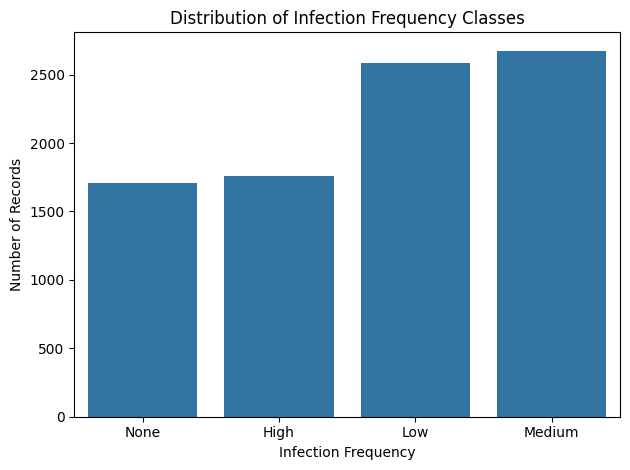

In [58]:
sns.countplot(
    data=df_demo,
    x='infection_label'
)
plt.title('Distribution of Infection Frequency Classes')
plt.xlabel('Infection Frequency')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

**Observation:**  
The dataset shows an **equal number of samples (n = 9)** for each infection frequency level.  
This indicates that the data were likely **balanced intentionally**, rather than reflecting a natural clinical distribution.  
Thus, the dataset appears designed for **comparative modeling** or **classification tasks**, not for epidemiological prevalence analysis.

> 🔍 **Remark:**  
> Infection frequencies are uniformly distributed across four categories (0–3).  
> This balance suggests a controlled dataset, which is useful for modeling but limits direct real-world inference about infection prevalence.

### 4.2 Is there a relationship between patient age and infection frequency, or are infections evenly distributed across age groups?

**Approach:**  
I first explored the age distribution for each bacterial strain using boxplots and density plots to identify potential age-related trends.  
I then quantified the relationship between `Age` and `Infection_Freq` using Spearman correlation and ANOVA to assess whether the differences in age across bacterial strains are statistically significant.

**Visualization:**  
The boxplot below shows the age distribution for the main bacterial strains observed in the dataset.

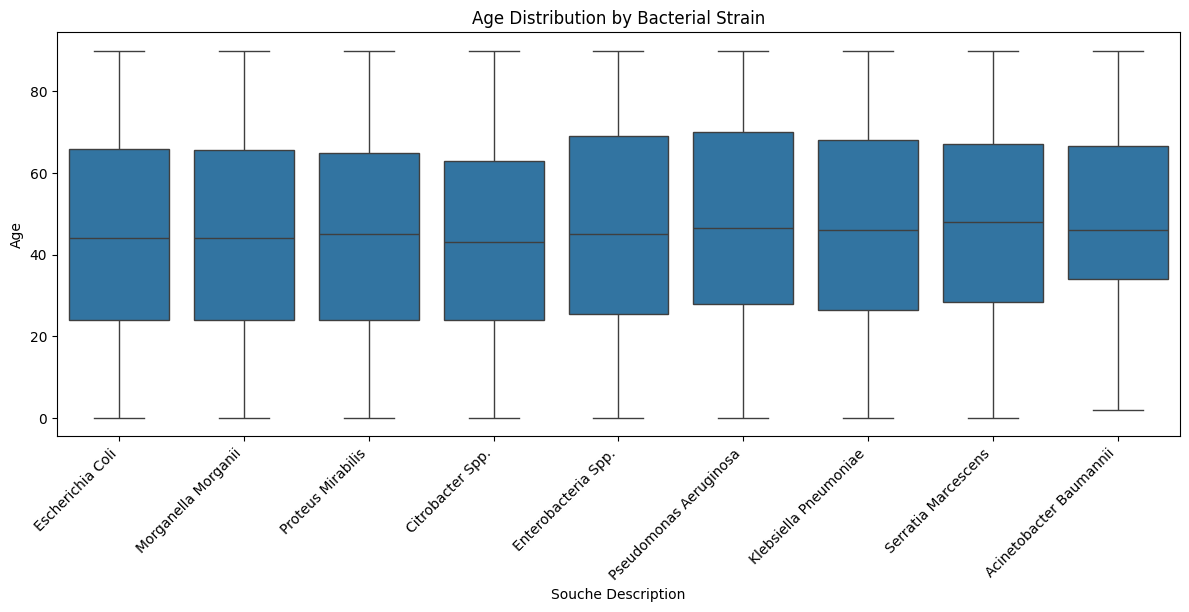

In [59]:
plt.figure(figsize=(12, 6))   # <-- imposti qui le dimensioni del canvas

sns.boxplot(data=df_demo, x='souche_description', y='age') 

plt.xticks(rotation=45, ha='right')  # ruota le etichette sull'asse X
plt.tight_layout()                   # ottimizza gli spazi
plt.xlabel('Souche Description')
plt.ylabel('Age')
plt.title('Age Distribution by Bacterial Strain')
plt.show()

In [60]:
# Calculate Spearman correlation between age and infection_freq

corr = df_demo[['age', 'infection_freq']].corr(method='spearman').iloc[0,1]
print(f"Spearman correlation (Age vs Infection_Freq): {corr:.3f}")

Spearman correlation (Age vs Infection_Freq): 0.007


In [61]:
from scipy.stats import f_oneway

# calculate ANOVA
groups = [group['age'].dropna().values for _, group in df_demo.groupby('souche_description')]
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.3e}")

ANOVA F = 1.275, p = 2.516e-01


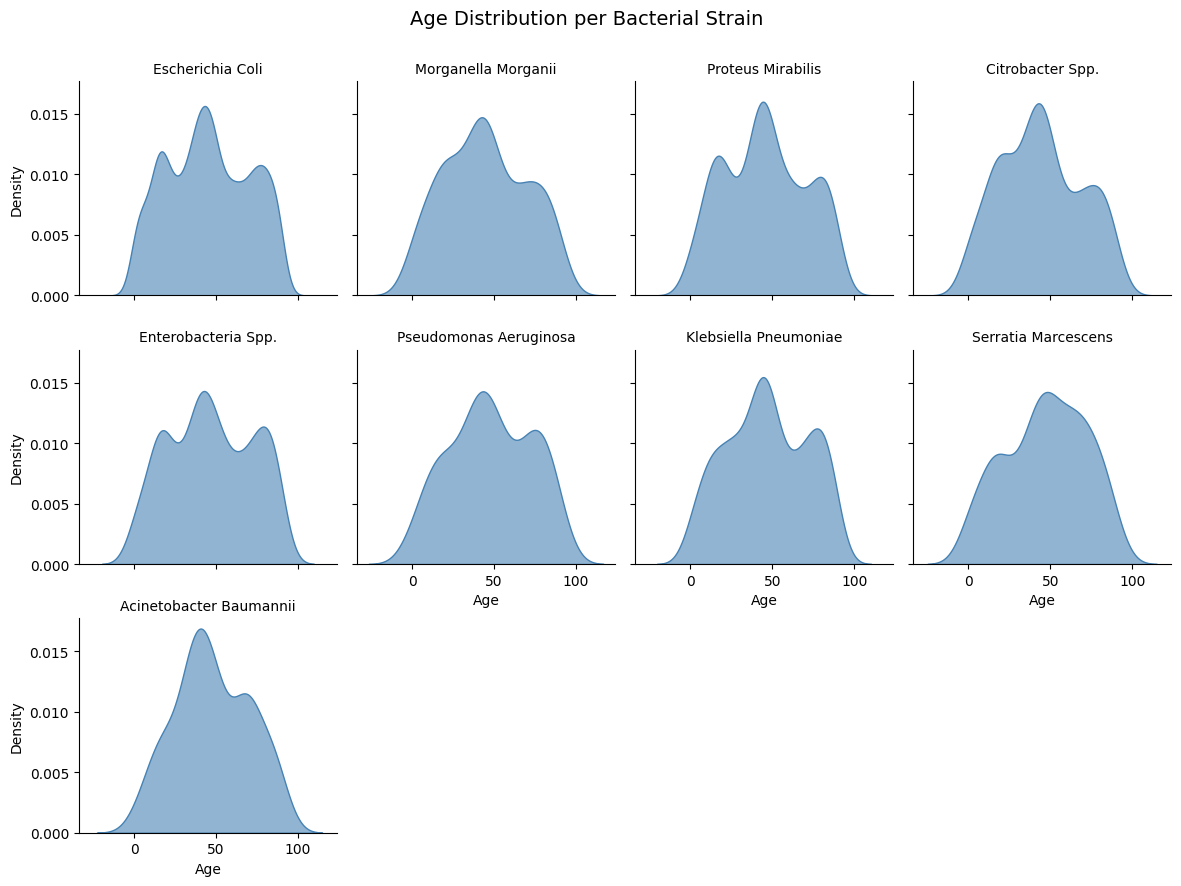

In [62]:
g = sns.FacetGrid(df_demo, col='souche_description', col_wrap=4, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, x='age', fill=True, color='steelblue', alpha=0.6)
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Age', 'Density')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Age Distribution per Bacterial Strain', fontsize=14)
plt.show()

**Observation:**  
The median age appears to be similar across most bacterial strains, typically ranging between 40 and 50 years.  
The spread of ages is broad and comparable, indicating that infections occur across all age groups without a clear concentration in a specific demographic.

To validate this observation statistically, we computed:
- **Spearman correlation (Age vs Infection_Freq):** `0.007`  
  → Suggests virtually *no monotonic relationship* between age and infection frequency.
- **ANOVA F = 1.275**, **p = 0.2516**  
  → Confirms that *age distributions do not significantly differ* among bacterial strains (p > 0.05).



### 4.4 How have infection frequencies evolved over time, and do these temporal trends differ between male and female patients?

**Approach:**  
To explore temporal dynamics, infection records were grouped by year, bacterial strain (`souche_description`), and gender.  
We then visualized the number of infections per year using a FacetGrid of line plots — each subplot representing one bacterial strain, with separate lines for male and female patients.

**Visualization:**  
The chart below illustrates infection trends over time (2019–2025) for the main bacterial strains.

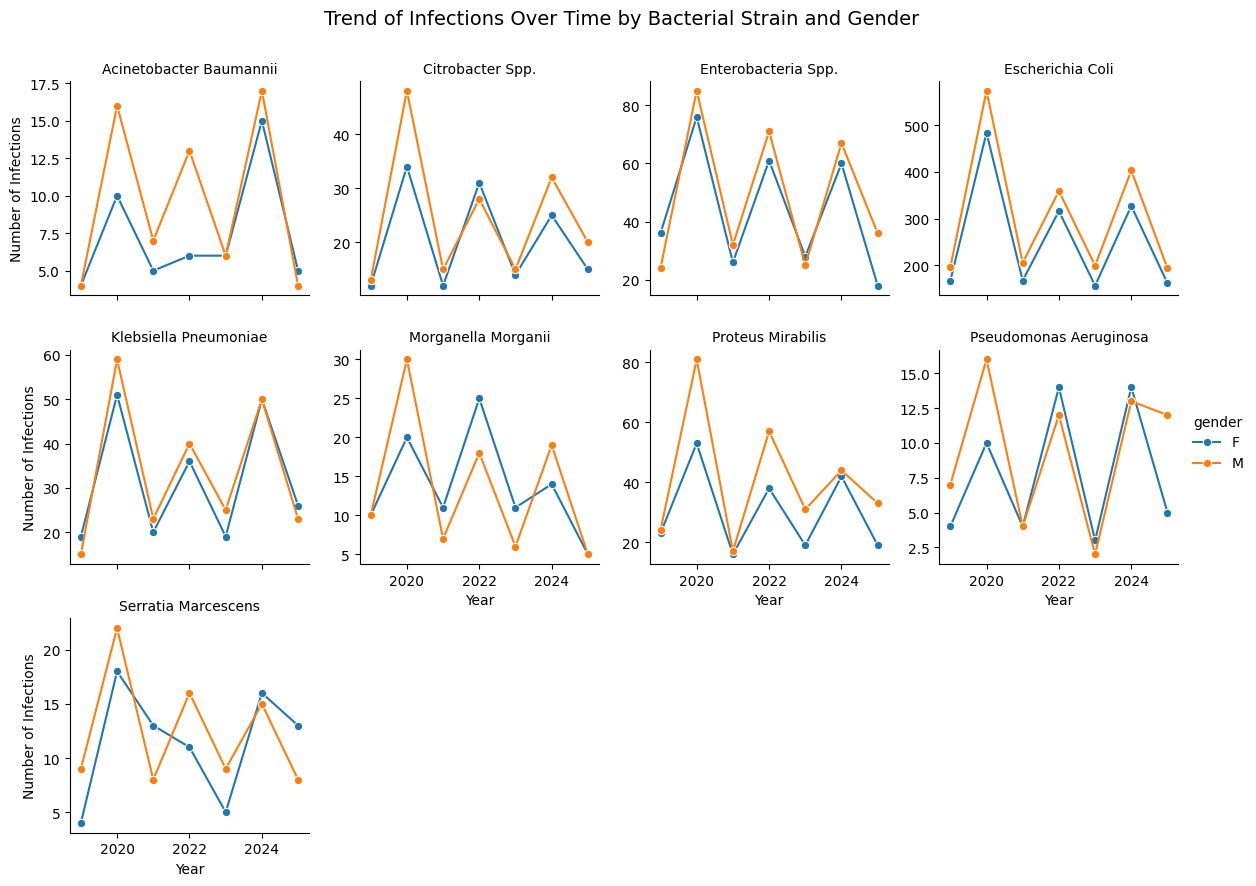

In [63]:
df_demo['year'] = df_demo['collection_date'].dt.year

infections_by_year_gender = (
    df_demo.groupby(['year', 'souche_description', 'gender'])
    .size()
    .reset_index(name='infection_count')
)

g = sns.FacetGrid(
    infections_by_year_gender,
    col='souche_description',
    col_wrap=4,
    height=3,
    sharey=False,
    hue='gender'
)
g.map_dataframe(sns.lineplot, x='year', y='infection_count', marker='o')
g.add_legend()
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Year', 'Number of Infections')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend of Infections Over Time by Bacterial Strain and Gender', fontsize=14)
plt.show()

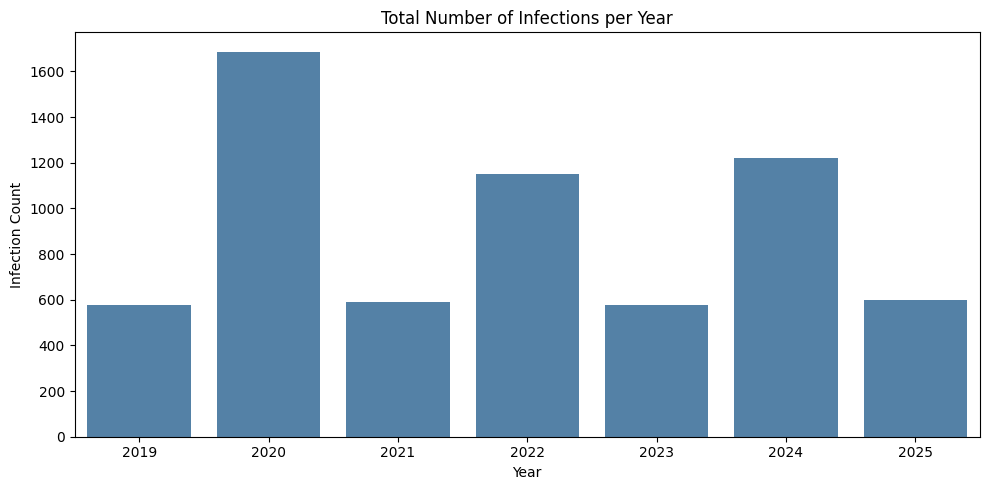

In [64]:
annual_trend = df_demo.groupby('year')['infection_freq'].count().reset_index(name='total_infections')

plt.figure(figsize=(10,5))
sns.barplot(data=annual_trend, x=annual_trend['year'].astype(int), y='total_infections', color='steelblue')
plt.title('Total Number of Infections per Year')
plt.xlabel('Year')
plt.ylabel('Infection Count')
plt.tight_layout()
plt.show()

In [65]:
import plotly.express as px

# Group by state
infections_by_state = (
    df_demo.groupby('state')
    .size()
    .reset_index(name='infection_count')
)

# Create a choropleth map
fig = px.choropleth(
    infections_by_state,
    locations='state',
    locationmode='USA-states',
    color='infection_count',
    color_continuous_scale='Blues',
    labels={'infection_count': 'Nr of Infections'},
    scope='usa',
    title='Geographic Distribution of Infections Across U.S. States'
)

fig.update_layout(
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    margin=dict(l=0, r=0, t=50, b=0),
    title_x=0.5
)


fig.show()

#### **Observations**

- The choropleth visualization shows a **relatively uniform distribution** of infection counts across U.S. states, with no evident geographic clusters or outliers.  
- **No consistent regional patterns** (e.g., North–South or East–West differences) emerge from the data.  
- Slight variations in intensity appear **random and not epidemiologically meaningful**, likely reflecting data variability rather than true spatial trends.  
- When combined with previous analyses (age, gender, and infection frequency), these results further support the idea of a **homogeneous dataset** without clear demographic or territorial dependencies.  
- In summary, **infection incidence appears evenly distributed nationwide**, suggesting either balanced data collection or the absence of regional infection drivers in the available records.  

### 4.5 Are certain bacterial species more frequently associated with higher infection levels?

**Approach:**  
The dataset was grouped by `souche_description` and `infection_label` to evaluate how infection severity is distributed across bacterial strains.  
A grouped bar plot was generated, where each bar represents the number of cases for a specific bacterial strain, segmented by infection level (`Low`, `Medium`, `High`, `None`).

In [66]:
df_clean = df[[
    'diabetes', 'hypertension', 'hospital_before', 'infection_freq', 'infection_label',
    'amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm', 'gen', 'an', 'acide nalidixique',
    'ofx', 'cip', 'c', 'co-trimoxazole', 'furanes', 'colistine',
    'collection_date', 'state', 'zip',
    'souche_id', 'souche_description', 'age', 'gender'
]]

df_clean

,diabetes,hypertension,hospital_before,infection_freq,infection_label,amx/amp,amc,cz,fox,ctx/cro,ipm,gen,an,acide nalidixique,ofx,cip,c,co-trimoxazole,furanes,colistine,collection_date,state,zip,souche_id,souche_description,age,gender
0,No,No,No,0.0,None,R,R,R,R,R,R,S,S,S,S,S,R,S,S,S,NaT,RI,30252,S290,Escherichia Coli,37.0,F
1,True,No,No,3.0,High,S,R,S,R,S,R,S,S,S,S,S,S,S,S,S,2021-05-08,HI,30310,S291,Morganella Morganii,29.0,F
2,True,No,No,3.0,High,S,R,S,R,S,S,S,S,S,S,R,R,S,S,S,2022-05-01,HI,85195,S292,Proteus Mirabilis,77.0,M
4,No,Yes,No,1.0,Low,S,S,R,R,R,R,R,R,S,S,S,S,S,S,S,NaT,ME,50811,S294,Escherichia Coli,13.0,F
5,True,No,No,3.0,High,R,S,R,R,S,S,S,R,S,S,S,S,S,S,S,2020-01-05,AA,98816,S295,Escherichia Coli,57.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10703,True,Yes,No,3.0,High,S,S,S,R,S,R,S,R,S,S,S,S,S,R,S,2024-12-31,FM,17501,S6240,Escherichia Coli,48.0,M
10704,No,No,No,0.0,None,S,R,R,R,S,S,S,S,R,S,S,R,S,S,S,NaT,RI,93324,S8862,Escherichia Coli,43.0,F
10706,True,No,Yes,3.0,High,S,R,S,S,S,S,S,S,S,S,S,S,S,S,S,NaT,SD,31189,S1479,Proteus Mirabilis,20.0,F
10707,No,No,No,0.0,None,R,R,S,R,R,R,S,S,S,R,S,R,S,S,S,2021-05-08,PW,17799,S2983,Escherichia Coli,33.0,F


In [67]:
bacteria_freq = (
    df_clean
    .groupby(['souche_description', 'infection_label'])
    .size()
    .reset_index(name='count')
)

bacteria_freq.sort_values(['souche_description', 'infection_label'], inplace=True)
bacteria_freq[bacteria_freq['infection_label'] == 'High'].sort_values('count', ascending=False)

bacteria_freq.head(4)

,souche_description,infection_label,count
0,Acinetobacter Baumannii,High,38
1,Acinetobacter Baumannii,Low,31
2,Acinetobacter Baumannii,Medium,60
3,Acinetobacter Baumannii,None,26


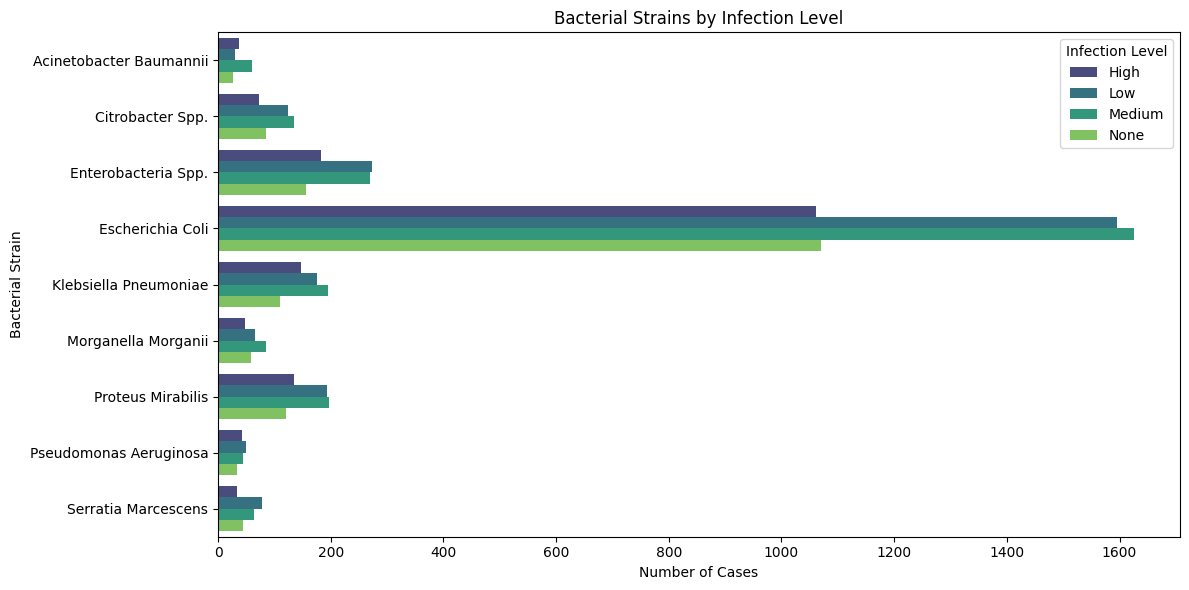

In [68]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=bacteria_freq,
    x='count',
    y='souche_description',
    hue='infection_label',
    palette='viridis'
)
plt.title('Bacterial Strains by Infection Level')
plt.xlabel('Number of Cases')
plt.ylabel('Bacterial Strain')
plt.legend(title='Infection Level', loc='upper right')
plt.tight_layout()
plt.show()

**Observations:**  
- *Escherichia coli* remains by far the most prevalent strain across all infection levels, confirming its dominant role in the dataset.  
- Although *E. coli* exhibits a higher total number of infections, the relative proportions across infection levels appear balanced, suggesting it affects both mild and severe cases.  
- *Klebsiella pneumoniae* and *Proteus mirabilis* also show a moderate presence in higher infection levels, consistent with their known clinical relevance.  
- Other species (*Serratia marcescens*, *Acinetobacter baumannii*, *Pseudomonas aeruginosa*) appear much less frequent, mostly confined to low or medium infection categories.  
- Overall, no single bacterial strain shows a disproportionate increase in severe infections — the pattern suggests a broadly uniform severity distribution across strains.

> **Remark:**  
> The analysis confirms that *E. coli* dominates the infection landscape in both frequency and diversity of severity levels, while other strains contribute modestly and proportionally to less severe infections. This may indicate a general stability in infection severity distribution across bacterial species rather than a strain-specific escalation pattern.

### 4.4 Resistance heatmap (bacteria × antibiotic)
Shows mean resistance rate per pair, filtered to frequent categories for readability.

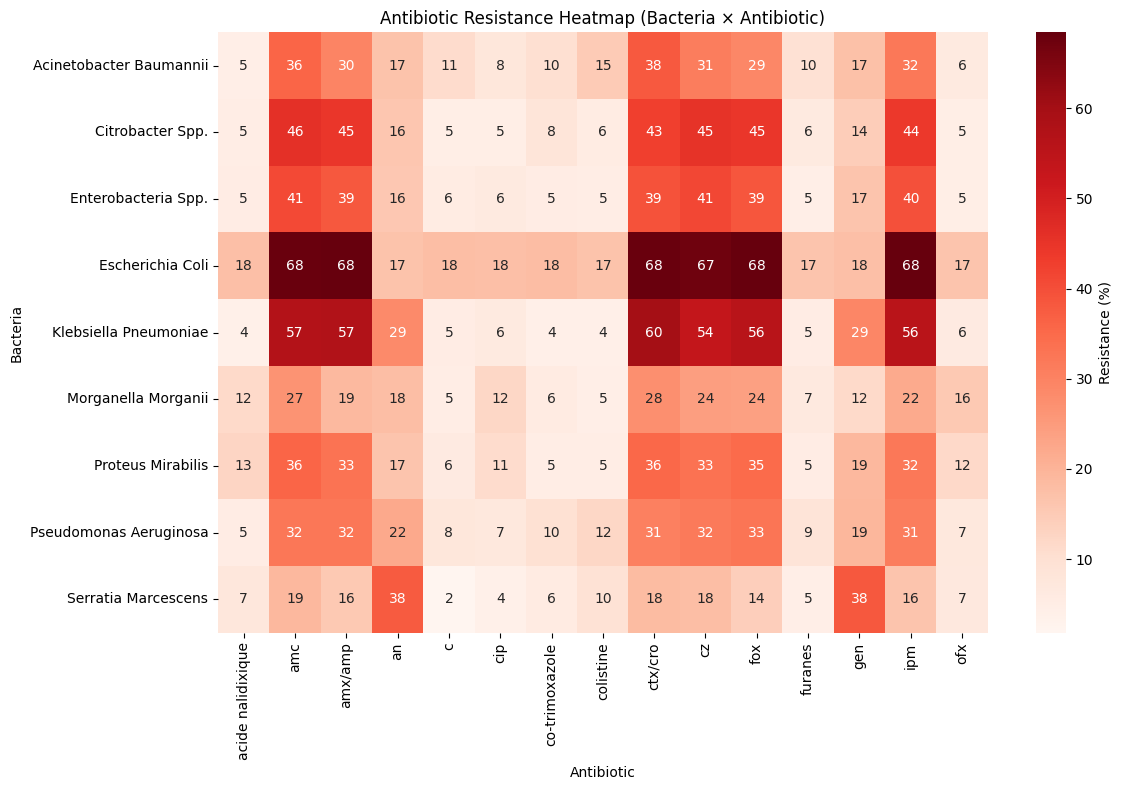

In [72]:
# List of antibiotic columns
ab_cols = [
    'amx/amp', 'amc', 'cz', 'fox', 'ctx/cro', 'ipm',
    'gen', 'an', 'acide nalidixique', 'ofx', 'cip', 'c',
    'co-trimoxazole', 'furanes', 'colistine'
]

# Reshape dataset to long format
long_df = df_clean.melt(
    id_vars='souche_description',   # nome della colonna con il batterio
    value_vars=ab_cols,             # antibiotici
    var_name='antibiotic',
    value_name='result'
)

# Create thr resistant column 
long_df['is_resistant'] = long_df['result'].eq('R')

# Calculate resistance rates
resistance_rate = (
    long_df
    .groupby(['souche_description', 'antibiotic'])['is_resistant']
    .mean()                      # media di True/False = proporzione
    .mul(100)                    # in percentuale
    .reset_index(name='resistance_pct')
)

heatmap_data = resistance_rate.pivot(
    index='souche_description',   # righe = batteri
    columns='antibiotic',         # colonne = antibiotici
    values='resistance_pct'       # celle = % resistente
)

heatmap_data = heatmap_data.sort_index()      # oppure sort_index(axis=1) per colonne



plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='Reds',
    annot=True, fmt='.0f',        # mostra la % intera
    cbar_kws={'label': 'Resistance (%)'}
)
plt.title('Antibiotic Resistance Heatmap (Bacteria × Antibiotic)')
plt.xlabel('Antibiotic')
plt.ylabel('Bacteria')
plt.tight_layout()
plt.show()

### Observations

- Resistance patterns form **three consistent clusters** across species (high, moderate, and low resistance groups).  
- *E. coli* and *K. pneumoniae* exhibit **broad multi-drug resistance**, especially to β-lactams.  
- Ciprofloxacin, imipenem, and colistin show **uniformly low resistance**, remaining among the most reliable therapeutic options.  
- Less frequent species (e.g., *Proteus*, *Serratia*) display **structured, non-random resistance profiles** aligned with known microbiology.  
- Overall, the heatmap indicates that resistance patterns are **predictable rather than random**, revealing clear clinical risks and treatment opportunities.

## 5. Preprocessing & Train/Test Split
We build a `ColumnTransformer` with one‑hot encoding for categorical variables. RandomForest is robust and handles mixed features well. We set `class_weight='balanced'` to cope with class imbalance.

In [78]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

pipe = Pipeline(steps=[('preprocess', preprocess), ('model', rf)])
pipe.fit(X_train, y_train)

print('Train/Test shapes:', X_train.shape, X_test.shape)

NameError: name 'target_col' is not defined

## 6. Evaluation
We report the classification metrics, confusion matrix (as a Plotly heatmap), and ROC‑AUC.

In [71]:
y_pred = pipe.predict(X_test)
y_prob = None
try:
    y_prob = pipe.predict_proba(X_test)[:, 1]
except Exception:
    pass

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
fig = px.imshow(cm, text_auto=True, title='Confusion Matrix', labels=dict(x='Predicted', y='True', color='count'))
fig.update_xaxes(tickmode='array', tickvals=[0,1], ticktext=['Sensitive (0)','Resistant (1)'])
fig.update_yaxes(tickmode='array', tickvals=[0,1], ticktext=['Sensitive (0)','Resistant (1)'])
fig.show()

if y_prob is not None:
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, th = roc_curve(y_test, y_prob)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC={auc:.3f})'))
    fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Chance', line=dict(dash='dash')))
    fig.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
    fig.show()

NameError: name 'pipe' is not defined

## 7. Feature Importance (Top 20)
We extract feature names after one‑hot encoding to display a clear, human‑readable importance chart.

In [70]:
# Get feature names from the ColumnTransformer
ohe = pipe.named_steps['preprocess'].named_transformers_['cat']
ohe_features = []
if hasattr(ohe, 'get_feature_names_out'):
    ohe_features = list(ohe.get_feature_names_out(cat_cols))

feature_names = ohe_features + num_cols

rf_model = pipe.named_steps['model']
importances = rf_model.feature_importances_

imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}) \
         .sort_values('importance', ascending=False) \
         .head(20)

fig = px.bar(imp_df, x='importance', y='feature', orientation='h', title='Top 20 Feature Importances')
fig.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig.show()
imp_df

NameError: name 'pipe' is not defined

## 8. Conclusions & Next Steps
- Summarize key resistance patterns by bacteria and antibiotic classes.
- Discuss model performance (precision/recall for resistant class, AUC).
- Outline concrete improvements:
  - Hyperparameter tuning (RandomizedSearchCV / Optuna).
  - Better handling of class imbalance (e.g., stratified sampling, threshold tuning).
  - Domain‑aware feature engineering (antibiotic classes, specimen source, time/region).
  - Comparing algorithms (XGBoost/LightGBM, calibrated models).

> 📝 Tip: If publishing on Kaggle, include a short **Methodology** and **Limitations** section in this notebook to improve credibility.
